# Mixture Density Network

Reproducing the classic Bishop MDN network tasks in Keras. The idea in this task is to predict a the value of an inverse sine function. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

There's a couple of other versions of this task, and this implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input, merge
from keras.engine.topology import Layer
import numpy as np
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
import tensorflow as tf

class MDN(Layer):
    """A Mixture Density Network Layer for Keras."""
    
    def __init__(self, output_dim, num_mix, **kwargs):
        self.output_dim = output_dim
        self.num_mix = num_mix
        with tf.name_scope('MDN'):
            self.mdn_mus     = Dense(self.num_mix * self.output_dim, name='mdn_mus') # mix*output vals, no activation
            self.mdn_sigmas  = Dense(self.num_mix * self.output_dim, activation=K.exp, name='mdn_sigmas') # mix*output vals exp activation
            self.mdn_pi      = Dense(self.num_mix, activation=K.softmax, name='mdn_pi') # mix vals, softmax
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)
        
    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x), 
                                                self.mdn_sigmas(x), 
                                                self.mdn_pi(x)], 
                                               name='mdn_outputs')
        return mdn_out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(probs=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss
    
    # Actually return the loss_func
    with tf.name_scope('MDN'):
        return loss_func
    
def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
        
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func
    
def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer 
    that takes one sample and compares to the true value."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func

Using TensorFlow backend.


## Generate Synthetic Data

Data generation

In [2]:
import matplotlib.pyplot as plt

## Generating some data:

NSAMPLE = 3000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((NSAMPLE, 1))

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

For this problem, we only need an output dimension of 1 as we are predicting one value (y). Adding more mixtures adds a more parameters (model is more complex, takes longer to train), but might help make the solutions better. You can see from the training data that there are at maximum 5 different layers to predict in the curve, so setting `N_MIXES = 5` is a good place to start.

For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [11]:
N_HIDDEN = 15
N_MIXES = 10

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(MDN(1, N_MIXES))
model.compile(loss=get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[get_mixture_mse_accuracy(1,3)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 15)                240       
_________________________________________________________________
mdn_2 (MDN)                  (None, 1)                 480       
Total params: 750
Trainable params: 750
Non-trainable params: 0
_________________________________________________________________


### Training the model

Now we train the model using Keras' normal `fit` command.

In [12]:
history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=1000, validation_split=0.15)

Train on 2550 samples, validate on 450 samples
Epoch 1/1000
2550/2550 [==============================] - 2s 607us/step - loss: 8.6744 - val_loss: 7.2837
Epoch 2/1000
2550/2550 [==============================] - 0s 31us/step - loss: 6.6214 - val_loss: 5.7471
Epoch 3/1000
2550/2550 [==============================] - 0s 30us/step - loss: 5.3717 - val_loss: 4.7623
Epoch 4/1000
2550/2550 [==============================] - 0s 30us/step - loss: 4.5668 - val_loss: 4.1532
Epoch 5/1000
2550/2550 [==============================] - 0s 31us/step - loss: 4.0617 - val_loss: 3.7704
Epoch 6/1000
2550/2550 [==============================] - 0s 31us/step - loss: 3.7868 - val_loss: 3.5969
Epoch 7/1000
2550/2550 [==============================] - 0s 31us/step - loss: 3.6176 - val_loss: 3.4712
Epoch 8/1000
2550/2550 [==============================] - 0s 31us/step - loss: 3.4988 - val_loss: 3.3748
Epoch 9/1000
2550/2550 [==============================] - 0s 31us/step - loss: 3.4102 - val_loss: 3.3054
Epoch 1

Epoch 78/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.8926 - val_loss: 1.8788
Epoch 79/1000
2550/2550 [==============================] - 0s 32us/step - loss: 1.8847 - val_loss: 1.8790
Epoch 80/1000
2550/2550 [==============================] - 0s 33us/step - loss: 1.8789 - val_loss: 1.8624
Epoch 81/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.8796 - val_loss: 1.8655
Epoch 82/1000
2550/2550 [==============================] - 0s 32us/step - loss: 1.8769 - val_loss: 1.8699
Epoch 83/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.8746 - val_loss: 1.8856
Epoch 84/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.8686 - val_loss: 1.8604
Epoch 85/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.8709 - val_loss: 1.8878
Epoch 86/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.8758 - val_loss: 1.8597
Epoch 87/1000
2550/2550 [=====================

Epoch 155/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.7031 - val_loss: 1.7181
Epoch 156/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.6890 - val_loss: 1.7010
Epoch 157/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.6910 - val_loss: 1.7192
Epoch 158/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.7020 - val_loss: 1.6931
Epoch 159/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.6843 - val_loss: 1.7012
Epoch 160/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.6872 - val_loss: 1.6924
Epoch 161/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.6851 - val_loss: 1.6856
Epoch 162/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.6835 - val_loss: 1.7132
Epoch 163/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.6831 - val_loss: 1.6917
Epoch 164/1000
2550/2550 [===========

2550/2550 [==============================] - 0s 32us/step - loss: 1.5452 - val_loss: 1.5649
Epoch 232/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.5433 - val_loss: 1.5558
Epoch 233/1000
2550/2550 [==============================] - 0s 32us/step - loss: 1.5407 - val_loss: 1.5591
Epoch 234/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.5442 - val_loss: 1.5507
Epoch 235/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.5415 - val_loss: 1.5861
Epoch 236/1000
2550/2550 [==============================] - 0s 32us/step - loss: 1.5526 - val_loss: 1.5498
Epoch 237/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.5545 - val_loss: 1.5623
Epoch 238/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.5458 - val_loss: 1.5572
Epoch 239/1000
2550/2550 [==============================] - 0s 39us/step - loss: 1.5395 - val_loss: 1.5472
Epoch 240/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 31us/step - loss: 1.5131 - val_loss: 1.5474
Epoch 308/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.5245 - val_loss: 1.5553
Epoch 309/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.5083 - val_loss: 1.5249
Epoch 310/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.5104 - val_loss: 1.5288
Epoch 311/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.5083 - val_loss: 1.5198
Epoch 312/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.5105 - val_loss: 1.5317
Epoch 313/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.5096 - val_loss: 1.5463
Epoch 314/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.5099 - val_loss: 1.5362
Epoch 315/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.5107 - val_loss: 1.5452
Epoch 316/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 31us/step - loss: 1.4788 - val_loss: 1.4964
Epoch 384/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4843 - val_loss: 1.4791
Epoch 385/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4856 - val_loss: 1.4816
Epoch 386/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4849 - val_loss: 1.5157
Epoch 387/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4916 - val_loss: 1.4833
Epoch 388/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4809 - val_loss: 1.4788
Epoch 389/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4817 - val_loss: 1.4727
Epoch 390/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4732 - val_loss: 1.4896
Epoch 391/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4924 - val_loss: 1.4888
Epoch 392/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 31us/step - loss: 1.4640 - val_loss: 1.4927
Epoch 460/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4661 - val_loss: 1.4627
Epoch 461/1000
2550/2550 [==============================] - 0s 32us/step - loss: 1.4591 - val_loss: 1.4856
Epoch 462/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4610 - val_loss: 1.4625
Epoch 463/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4541 - val_loss: 1.4777
Epoch 464/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4664 - val_loss: 1.4724
Epoch 465/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4546 - val_loss: 1.4738
Epoch 466/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4537 - val_loss: 1.4655
Epoch 467/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4545 - val_loss: 1.4663
Epoch 468/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 31us/step - loss: 1.4443 - val_loss: 1.4526
Epoch 536/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4358 - val_loss: 1.4520
Epoch 537/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4362 - val_loss: 1.4504
Epoch 538/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4372 - val_loss: 1.4499
Epoch 539/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4399 - val_loss: 1.4755
Epoch 540/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4405 - val_loss: 1.4472
Epoch 541/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4446 - val_loss: 1.4856
Epoch 542/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4506 - val_loss: 1.4438
Epoch 543/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4496 - val_loss: 1.4610
Epoch 544/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 30us/step - loss: 1.4277 - val_loss: 1.4340
Epoch 612/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4320 - val_loss: 1.4388
Epoch 613/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4301 - val_loss: 1.4381
Epoch 614/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4286 - val_loss: 1.4309
Epoch 615/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4249 - val_loss: 1.4327
Epoch 616/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4235 - val_loss: 1.4306
Epoch 617/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4227 - val_loss: 1.4327
Epoch 618/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4280 - val_loss: 1.4277
Epoch 619/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.4251 - val_loss: 1.4269
Epoch 620/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 30us/step - loss: 1.4176 - val_loss: 1.4196
Epoch 688/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4065 - val_loss: 1.4351
Epoch 689/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4108 - val_loss: 1.4344
Epoch 690/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4172 - val_loss: 1.4102
Epoch 691/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4088 - val_loss: 1.4099
Epoch 692/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4017 - val_loss: 1.4124
Epoch 693/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4027 - val_loss: 1.4225
Epoch 694/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4210 - val_loss: 1.4147
Epoch 695/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.4108 - val_loss: 1.4216
Epoch 696/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 30us/step - loss: 1.3941 - val_loss: 1.3968
Epoch 764/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3950 - val_loss: 1.4122
Epoch 765/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3952 - val_loss: 1.4074
Epoch 766/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3952 - val_loss: 1.3955
Epoch 767/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3905 - val_loss: 1.3941
Epoch 768/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3844 - val_loss: 1.3995
Epoch 769/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3914 - val_loss: 1.3933
Epoch 770/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3894 - val_loss: 1.3969
Epoch 771/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3862 - val_loss: 1.4135
Epoch 772/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 31us/step - loss: 1.3700 - val_loss: 1.3821
Epoch 840/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3716 - val_loss: 1.3925
Epoch 841/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3663 - val_loss: 1.3879
Epoch 842/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3660 - val_loss: 1.3757
Epoch 843/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3705 - val_loss: 1.3866
Epoch 844/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3719 - val_loss: 1.3912
Epoch 845/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3628 - val_loss: 1.3780
Epoch 846/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3679 - val_loss: 1.3753
Epoch 847/1000
2550/2550 [==============================] - 0s 31us/step - loss: 1.3722 - val_loss: 1.3834
Epoch 848/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 30us/step - loss: 1.3565 - val_loss: 1.3661
Epoch 916/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3534 - val_loss: 1.3764
Epoch 917/1000
2550/2550 [==============================] - 0s 29us/step - loss: 1.3557 - val_loss: 1.3830
Epoch 918/1000
2550/2550 [==============================] - 0s 29us/step - loss: 1.3518 - val_loss: 1.3946
Epoch 919/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3564 - val_loss: 1.3709
Epoch 920/1000
2550/2550 [==============================] - 0s 29us/step - loss: 1.3572 - val_loss: 1.3743
Epoch 921/1000
2550/2550 [==============================] - 0s 30us/step - loss: 1.3488 - val_loss: 1.3738
Epoch 922/1000
2550/2550 [==============================] - 0s 29us/step - loss: 1.3596 - val_loss: 1.3731
Epoch 923/1000
2550/2550 [==============================] - 0s 29us/step - loss: 1.3531 - val_loss: 1.3750
Epoch 924/1000
2550/2550 [==========================

2550/2550 [==============================] - 0s 33us/step - loss: 1.3526 - val_loss: 1.3718
Epoch 992/1000
2550/2550 [==============================] - 0s 34us/step - loss: 1.3514 - val_loss: 1.3761
Epoch 993/1000
2550/2550 [==============================] - 0s 33us/step - loss: 1.3528 - val_loss: 1.3851
Epoch 994/1000
2550/2550 [==============================] - 0s 33us/step - loss: 1.3507 - val_loss: 1.3756
Epoch 995/1000
2550/2550 [==============================] - 0s 35us/step - loss: 1.3445 - val_loss: 1.3596
Epoch 996/1000
2550/2550 [==============================] - 0s 33us/step - loss: 1.3474 - val_loss: 1.3655
Epoch 997/1000
2550/2550 [==============================] - 0s 33us/step - loss: 1.3413 - val_loss: 1.3533
Epoch 998/1000
2550/2550 [==============================] - 0s 33us/step - loss: 1.3383 - val_loss: 1.3635
Epoch 999/1000
2550/2550 [==============================] - 0s 34us/step - loss: 1.3407 - val_loss: 1.3682
Epoch 1000/1000
2550/2550 [=========================

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point training is rather slow.

For this problem a loss value around 1.5 produces quite good results.

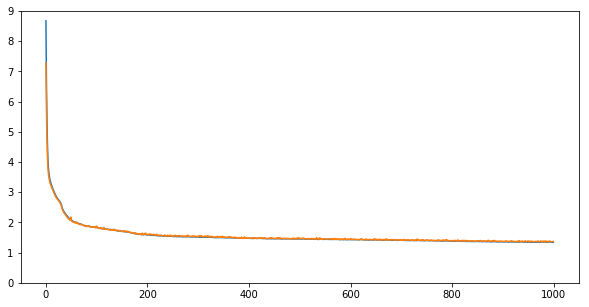

In [13]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

Below we have some functiosn to split up these parameters and sample from the normal distributions that they form.

In [6]:
# Sample from Categorical distribution
def sample_mixture(mus, sigs, pis):
    """Sample from a mixture of 1D normal distributions parameterised by mus, sigma, and pi."""
    m = np.random.choice(range(len(pis)), p=pis)
    return(np.random.normal(mus[m],sigs[m],1))

def split_mixture_params(params, mixtures, dim):
    """Splits up an array of mixture parameters into mus, sigmas, and pis 
    depending on the number of mixtures and output dimension."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[2*mixtures*dim:]
    return mus,sigs,pis

def adjust_temp(pi_pdf, temp):
    """ Adjusts temperature of a PDF describing a categorical model """
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a categorical model PDF, optionally greedily."""
    if greedy:
        return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1

def sample_from_categorical(dist, temp):
    """Sample from a categorical model with temperature adjustment."""
    r = np.random.rand(1)
    return get_pi_idx(r,dist,temp)

def sample_from_output(params, mixtures, dim, temp=1.0):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[-mixtures:]
    m = sample_from_categorical(pis, temp=temp)
    return(np.random.normal(mus[m],sigs[m],1))

## Try out the MDN Model

Now we try out the model by making predictions at 3000 evenly spaced points on the x-axis. 

Mixture models output lists of parameters, so we're going to sample from these parameters for each point on the x-axis, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [14]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples = np.apply_along_axis(sample_from_output, 1, y_test, N_MIXES,1,temp=1.0)

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test)
pis = np.apply_along_axis((lambda a: a[2*N_MIXES:]),1, y_test)

Testing: 3000 samples.


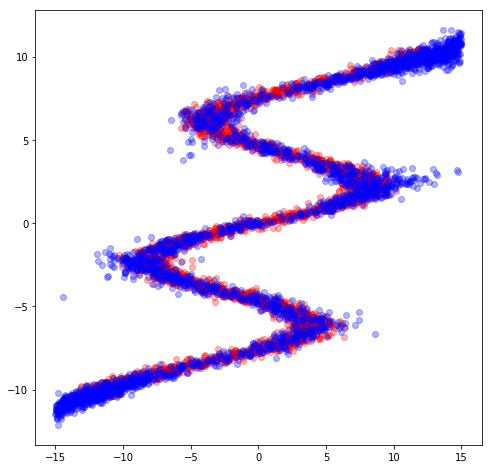

In [15]:
# Plot the samples
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples, 'bo',alpha=0.3)
plt.show()
# These look pretty good!

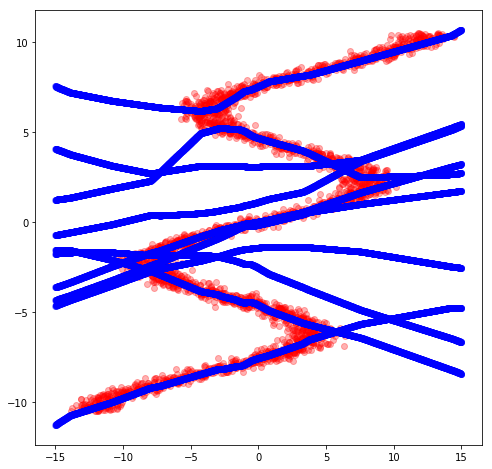

In [18]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, mus,'bo',alpha=0.3)
plt.show()
# Cool!

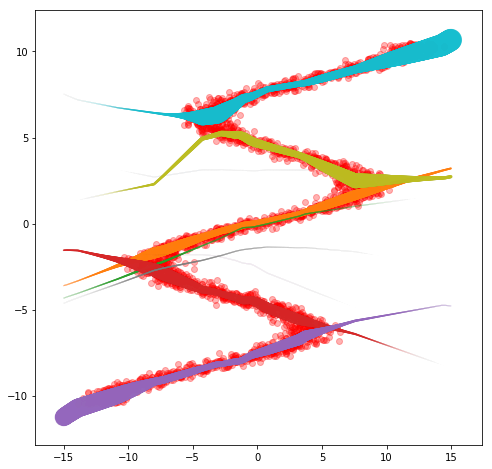

In [17]:
# Let's plot the variances and weightings of the means as well.
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
# ax1.scatter(data[0], data[1], marker='o', c='b', s=data[2], label='the data')
ax1.scatter(x_data,y_data,marker='o', c='r', alpha=0.3)
for i in range(N_MIXES):
    ax1.scatter(x_test, mus[:,i], marker='o', s=1000*sigs[:,i]*pis[:,i],alpha=0.3)
plt.show()